## CS 543 MP 2 - Part 2

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cv2
import skimage
from skimage import img_as_float
from skimage import io
from skimage import color
import PIL
from PIL import Image
from skimage import feature
import time

In [2]:
dir_name = 'C:\\Users\\Rachneet Kaur\\Desktop\\UIUC\\UIUC Spring 2019\\CS 543 CV\\MP2\\assignment2_images\\'

In [3]:
#Plotting an image 
def plot_image(image, name = 'image'):
    plt.figure(figsize = (7,7))
    plt.imshow(image)
    plt.savefig(name + '.jpg')

In [783]:
#Function to show the blob circles on the image 
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

## Inefficient Algorithm

In [1035]:
#Efficient implementation 
#Iteratively downsampling the image with a constant factor and saving the state space as square of normalized laplacian of gaussian 
def inefficient_algo(data, init_scale = 2, k = 0.75, n = 10):
    scale = init_scale
    scale_space = np.empty((data.shape[0], data.shape[1], n)) # [h,w] - dimensions of image, n - number of levels in scale space
    scale_space_max = np.empty((data.shape[0], data.shape[1], n))
    scale_space_preserve = np.empty((data.shape[0], data.shape[1], n))
    
    for i in range(n):
        data1_filt = scipy.ndimage.gaussian_laplace((scale**2)*data, sigma = scale)
        data1_filt_square = (data1_filt**2)
        scale_space[:, :, i] = data1_filt_square
        scale = k*scale
        
    #Non maximum supression in 2D scale 
    for i in range(n):
        scale_space_max[:, :, i] = scipy.ndimage.filters.rank_filter(scale_space[:, :, i], -1, 8) #Finding out the max in 3*3 matrix in each 2D scale 
        #Clipping the values which are less than a threshold to ignore them while computing the centers of interest
        #print ('Threshold for max supression = ', np.percentile(scale_space_max, 95))
        scale_space_max[:, :, i] = np.clip(scale_space_max[:,:,i], a_min = np.percentile(scale_space_max, 95), a_max = None) 
        scale_space_max[:, :, i][~(scale_space[:, :, i]==scale_space_max[:, :, i])] = 0 #Zeroing whichever is not the max
        
    scale_space_max_3D = scipy.ndimage.filters.rank_filter(scale_space_max, -1, 3)
    scale_space_max_3D[~(scale_space_max==scale_space_max_3D)] = 0 #Zeroing whichever is not the max after 3D non maximum supression

    cy = np.where(scale_space_max_3D!=0)[0]
    cx = np.where(scale_space_max_3D!=0)[1]
    sigma_list = init_scale*(k**np.where(scale_space_max_3D!=0)[2])
    rad = np.sqrt(2)*sigma_list
    
    #Pruning the blobs at the edges 
    cy1 = cy[~(np.logical_and(cy>=0, cy<=2)) ]
    cx1 = cx[~(np.logical_and(cy>=0, cy<=2))]
    sigma_list1 = sigma_list[~(np.logical_and(cy>=0, cy<=2))]
    rad1 = np.sqrt(2)*sigma_list1

    cy2 = cy1[~np.logical_and(cx1>=0, cx1<=2)]
    cx2 = cx1[~(np.logical_and(cx1>=0, cx1<=2))]
    sigma_list2 = sigma_list1[~(np.logical_and(cx1>=0, cx1<=2))]
    rad2 = np.sqrt(2)*sigma_list2

    cy3  = cy2[~np.logical_and(cy2>=(data.shape[0]-4), cy2<=(data.shape[0]-1))]
    cx3 = cx2[~np.logical_and(cy2>=(data.shape[0]-4), cy2<=(data.shape[0]-1))]
    sigma_list3 = sigma_list2[~np.logical_and(cy2>=(data.shape[0]-4), cy2<=(data.shape[0]-1))]
    rad3 = np.sqrt(2)*sigma_list3

    cy4  = cy3[~np.logical_and(cx3>=(data.shape[1]-4), cx3<=(data.shape[1]-1))]
    cx4 = cx3[~np.logical_and(cx3>=(data.shape[1]-4), cx3<=(data.shape[1]-1))]
    sigma_list4 = sigma_list3[~np.logical_and(cx3>=(data.shape[1]-4), cx3<=(data.shape[1]-1))]
    rad4 = np.sqrt(2)*sigma_list4
    
    return cy4, cx4, sigma_list4, rad4


## Given image 1

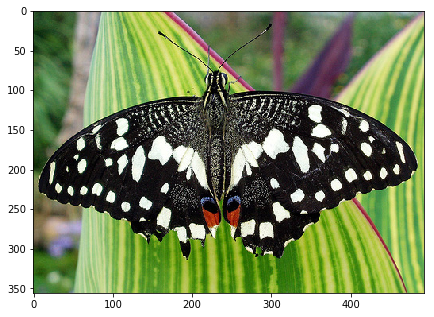

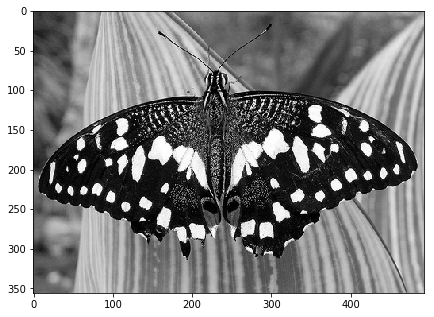

In [1036]:
#Given image 1
image1 = Image.open(dir_name + 'butterfly.jpg')
plot_image(image1)

#Converting image to grayscale image
image1_gray = image1.convert('L') #Grayscaled - Given image 1
plot_image(image1_gray, 'image1_gray')

In [1037]:
#Converting images to float type
data1 =  np.array(image1_gray, dtype=float)

#Rescaling image to between 0 and 1
data1_norm = data1/255.0

In [1038]:
init_scale = 1 #Initial scale  
k = 1.25 #The factor which is multiplied by scale each time 
n = 10 #No. of levels in the scale space n 

In [1039]:
#Running the inefficient algorithm and displaying the blobs on the image 
start_time = time.time()
cy4, cx4, sigma_list4, rad4 = inefficient_algo(data1, init_scale, k, n)
print ('Time for inefficient implementation = ', time.time()-start_time)
#show_all_circles(data1, cx4, cy4, rad4, color='r')

Time for inefficient implementation =  0.7368292808532715


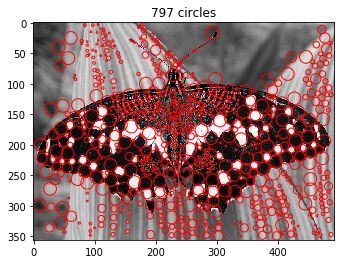

In [1040]:
#Pruning the extra blobs which are overlapping
a = skimage.feature.blob._prune_blobs(np.row_stack((cy4, cx4, sigma_list4)).T, 0.1)
cy_ = a.T[0]
cx_ = a.T[1]
sigma_list_ = a.T[2]
rad_ = np.sqrt(2)*sigma_list_
show_all_circles(data1, cx_, cy_, rad_, color='r')

## Given image 2

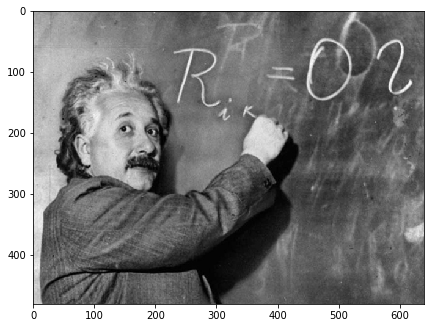

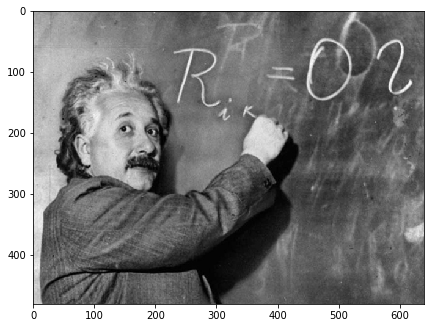

In [960]:
#Given image 2
image2 = Image.open(dir_name + 'einstein.jpg')
plot_image(image2)

#Converting image to grayscale image
image2_gray = image2.convert('L') #Grayscaled - Given image 1
plot_image(image2_gray, 'image2_gray')

In [961]:
#Converting images to float type
data2 =  np.array(image2_gray, dtype=float)

#Rescaling image to between 0 and 1
data2_norm = data2/255.0

In [995]:
init_scale = 2 #Initial scale  
k = 1.5 #The factor which is multiplied by scale each time 
n = 6 #No. of levels in the scale space n 

In [1002]:
#Running the inefficient algorithm and displaying the blobs on the image 
start_time = time.time()
cy4, cx4, sigma_list4, rad4 = inefficient_algo(data2, init_scale, k, n)
print ('Time for inefficient implementation = ', time.time()-start_time)
#show_all_circles(data2, cx4, cy4, rad4, color='r')

Time for inefficient implementation =  0.7811117172241211


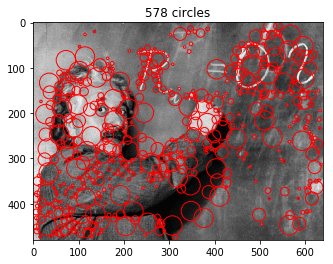

In [1003]:
#Pruning the extra blobs which are overlapping
a = skimage.feature.blob._prune_blobs(np.row_stack((cy4, cx4, sigma_list4)).T, 0.6)
cy_ = a.T[0]
cx_ = a.T[1]
sigma_list_ = a.T[2]
rad_ = np.sqrt(2)*sigma_list_
show_all_circles(data2, cx_, cy_, rad_, color='r')

## Given image 3

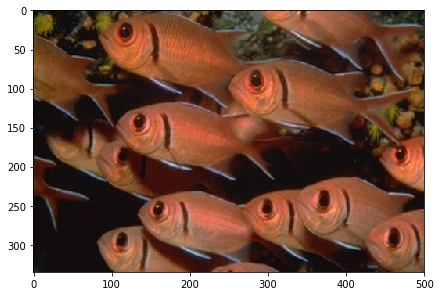

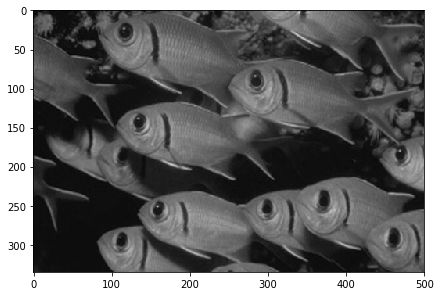

In [1004]:
#Given image 3
image3 = Image.open(dir_name + 'fishes.jpg')
plot_image(image3)

#Converting image to grayscale image
image3_gray = image3.convert('L') #Grayscaled - Given image 1
plot_image(image3_gray, 'image3_gray')

In [1005]:
#Converting images to float type
data3 =  np.array(image3_gray, dtype=float)

#Rescaling image to between 0 and 1
data3_norm = data3/255.0

In [1021]:
init_scale = 2 #Initial scale  
k = 1.5 #The factor which is multiplied by scale each time 
n = 7 #No. of levels in the scale space n 

In [1027]:
#Running the inefficient algorithm and displaying the blobs on the image 
start_time = time.time()
cy4, cx4, sigma_list4, rad4 = inefficient_algo(data3, init_scale, k, n)
print ('Time for inefficient implementation = ', time.time()-start_time)
#show_all_circles(data3, cx4, cy4, rad4, color='r')

Time for inefficient implementation =  0.5831873416900635


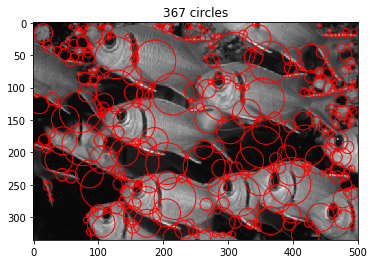

In [1029]:
#Pruning the extra blobs which are overlapping
a = skimage.feature.blob._prune_blobs(np.row_stack((cy4, cx4, sigma_list4)).T, 0.8)
cy_ = a.T[0]
cx_ = a.T[1]
sigma_list_ = a.T[2]
rad_ = np.sqrt(2)*sigma_list_
show_all_circles(data3, cx_, cy_, rad_, color='r')

## Given image 4

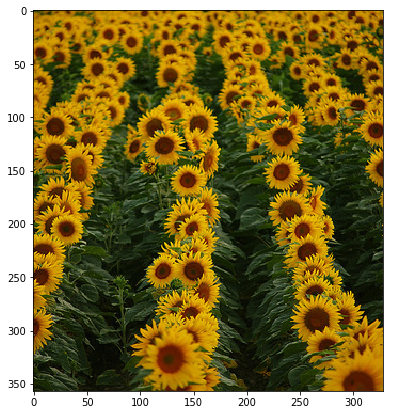

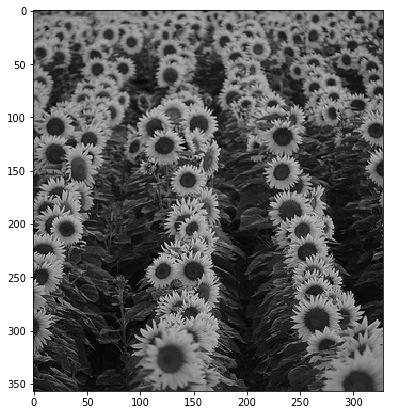

In [1041]:
#Given image 4
image4 = Image.open(dir_name + 'sunflowers.jpg')
plot_image(image4)

#Converting image to grayscale image
image4_gray = image4.convert('L') #Grayscaled - Given image 1
plot_image(image4_gray, 'image4_gray')

In [1042]:
#Converting images to float type
data4 =  np.array(image4_gray, dtype=float)

#Rescaling image to between 0 and 1
data4_norm = data4/255.0

In [1043]:
init_scale = 2 #Initial scale  
k = 1.25 #The factor which is multiplied by scale each time 
n = 10 #No. of levels in the scale space n 

In [1047]:
#Running the inefficient algorithm and displaying the blobs on the image 
start_time = time.time()
cy4, cx4, sigma_list4, rad4 = inefficient_algo(data4, init_scale, k, n)
print ('Time for inefficient implementation = ', time.time()-start_time)
#show_all_circles(data4, cx4, cy4, rad4, color='r')

Time for inefficient implementation =  0.54496169090271


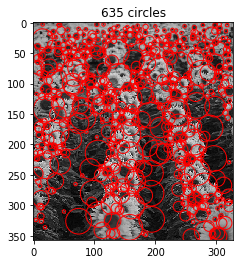

In [1046]:
#Pruning the extra blobs which are overlapping
a = skimage.feature.blob._prune_blobs(np.row_stack((cy4, cx4, sigma_list4)).T, 0.9)
cy_ = a.T[0]
cx_ = a.T[1]
sigma_list_ = a.T[2]
rad_ = np.sqrt(2)*sigma_list_
show_all_circles(data4, cx_, cy_, rad_, color='r')

## New image 1

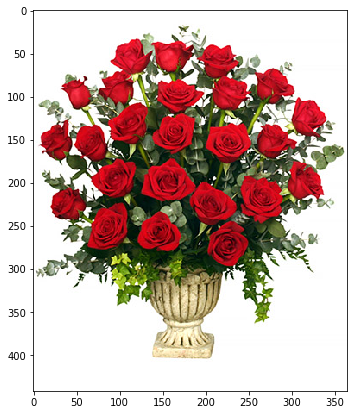

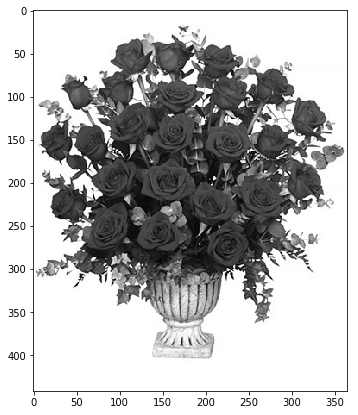

In [1048]:
#Given image 5
image5 = Image.open(dir_name + 'roses.jpg')
plot_image(image5)

#Converting image to grayscale image
image5_gray = image5.convert('L') #Grayscaled - Given image 5
plot_image(image5_gray, 'image5_gray')

In [1049]:
#Converting images to float type
data5 =  np.array(image5_gray, dtype=float)

#Rescaling image to between 0 and 1
data5_norm = data5/255.0

In [1053]:
init_scale = 2 #Initial scale  
k = 1.25 #The factor which is multiplied by scale each time 
n = 10 #No. of levels in the scale space n 

In [1065]:
#Running the inefficient algorithm and displaying the blobs on the image 
start_time = time.time()
cy4, cx4, sigma_list4, rad4 = inefficient_algo(data5, init_scale, k, n)
print ('Time for inefficient implementation = ', time.time()-start_time)
#show_all_circles(data5, cx4, cy4, rad4, color='r')

Time for inefficient implementation =  0.5776917934417725


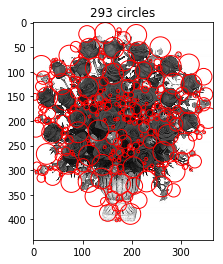

In [1055]:
#Pruning the extra blobs which are overlapping
a = skimage.feature.blob._prune_blobs(np.row_stack((cy4, cx4, sigma_list4)).T, 0.4)
cy_ = a.T[0]
cx_ = a.T[1]
sigma_list_ = a.T[2]
rad_ = np.sqrt(2)*sigma_list_
show_all_circles(data5, cx_, cy_, rad_, color='r')

## New image 2


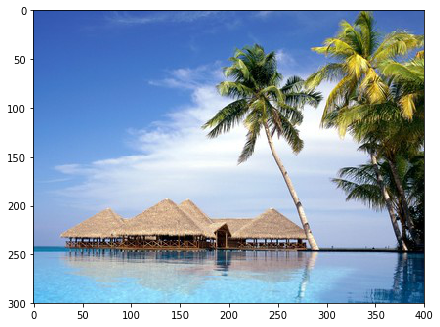

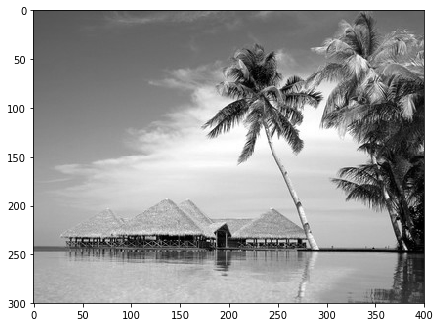

In [1056]:
#Given image 6
image6 = Image.open(dir_name + 'huts.jpg')
plot_image(image6)

#Converting image to grayscale image
image6_gray = image6.convert('L') #Grayscaled - Given image 5
plot_image(image6_gray, 'image6_gray')

In [1057]:
#Converting images to float type
data6 =  np.array(image6_gray, dtype=float)

#Rescaling image to between 0 and 1
data6_norm = data6/255.0

In [1061]:
init_scale = 2 #Initial scale  
k = 1.25 #The factor which is multiplied by scale each time 
n = 8 #No. of levels in the scale space n 

In [1063]:
#Running the inefficient algorithm and displaying the blobs on the image 
start_time = time.time()
cy4, cx4, sigma_list4, rad4 = inefficient_algo(data6, init_scale, k, n)
print ('Time for inefficient implementation = ', time.time()-start_time)
#show_all_circles(data6, cx4, cy4, rad4, color='r')

Time for inefficient implementation =  0.3275754451751709


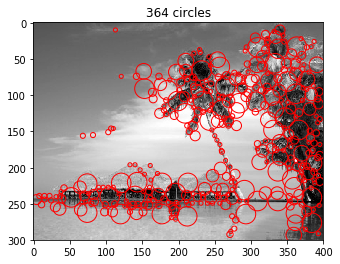

In [1064]:
#Pruning the extra blobs which are overlapping
a = skimage.feature.blob._prune_blobs(np.row_stack((cy4, cx4, sigma_list4)).T, 0.7)
cy_ = a.T[0]
cx_ = a.T[1]
sigma_list_ = a.T[2]
rad_ = np.sqrt(2)*sigma_list_
show_all_circles(data6, cx_, cy_, rad_, color='r')

## New image 3

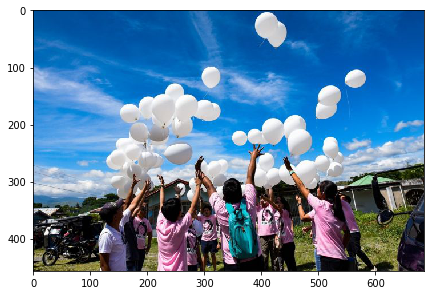

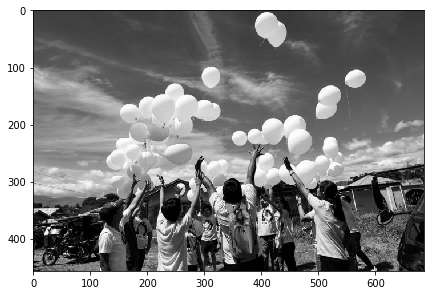

In [1066]:
#Given image 7
image7 = Image.open(dir_name + 'balloons.jpg')
plot_image(image7)

#Converting image to grayscale image
image7_gray = image7.convert('L') #Grayscaled - Given image 5
plot_image(image7_gray, 'image7_gray')

In [1067]:
#Converting images to float type
data7 =  np.array(image7_gray, dtype=float)

#Rescaling image to between 0 and 1
data7_norm = data7/255.0

In [1077]:
init_scale = 2 #Initial scale  
k = 1.5 #The factor which is multiplied by scale each time 
n =  7 #No. of levels in the scale space n 

In [1080]:
#Running the inefficient algorithm and displaying the blobs on the image 
start_time = time.time()
cy4, cx4, sigma_list4, rad4 = inefficient_algo(data7, init_scale, k, n)
print ('Time for inefficient implementation = ', time.time()-start_time)
#show_all_circles(data7, cx4, cy4, rad4, color='r')

Time for inefficient implementation =  0.9674108028411865


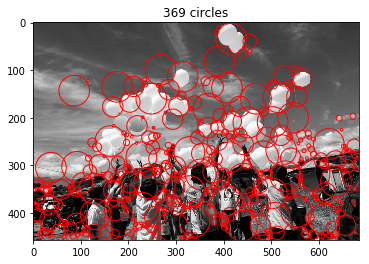

In [1079]:
#Pruning the extra blobs which are overlapping
a = skimage.feature.blob._prune_blobs(np.row_stack((cy4, cx4, sigma_list4)).T, 0.7)
cy_ = a.T[0]
cx_ = a.T[1]
sigma_list_ = a.T[2]
rad_ = np.sqrt(2)*sigma_list_
show_all_circles(data7, cx_, cy_, rad_, color='r')

## New image 4

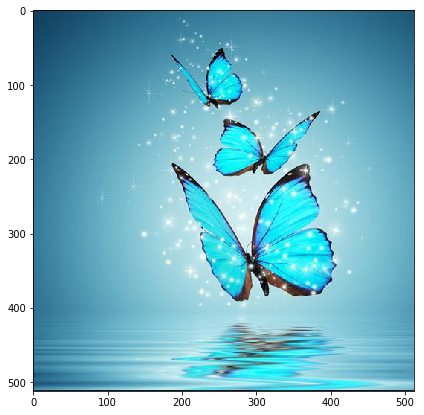

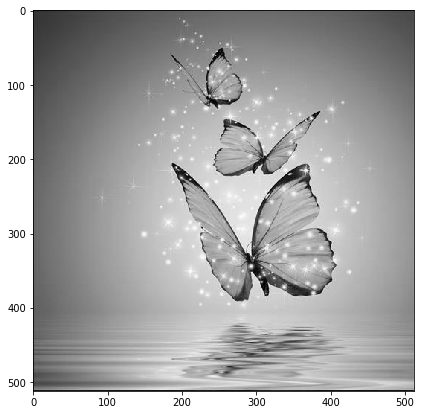

In [848]:
#Given image 8
image8 = Image.open(dir_name + 'blues.png')
plot_image(image8)

#Converting image to grayscale image
image8_gray = image8.convert('L') #Grayscaled - Given image 5
plot_image(image8_gray, 'image8_gray')

In [849]:
#Converting images to float type
data8 =  np.array(image8_gray, dtype=float)

#Rescaling image to between 0 and 1
data8_norm = data8/255.0

In [853]:
init_scale = 1 #Initial scale  
k = 1.5 #The factor which is multiplied by scale each time 
n = 10 #No. of levels in the scale space n 

In [1081]:
#Running the inefficient algorithm and displaying the blobs on the image 
start_time = time.time()
cy4, cx4, sigma_list4, rad4 = inefficient_algo(data8, init_scale, k, n)
print ('Time for inefficient implementation = ', time.time()-start_time)
#show_all_circles(data8, cx4, cy4, rad4, color='r')

Time for inefficient implementation =  0.7400162220001221


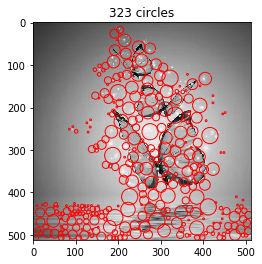

In [858]:
#Pruning the extra blobs which are overlapping
a = skimage.feature.blob._prune_blobs(np.row_stack((cy4, cx4, sigma_list4)).T, 0.2)
cy_ = a.T[0]
cx_ = a.T[1]
sigma_list_ = a.T[2]
rad_ = np.sqrt(2)*sigma_list_
show_all_circles(data8, cx_, cy_, rad_, color='r')

# Efficient algorithm

In [1091]:
#Efficient implementation 
#Iteratively downsampling the image with a constant factor and saving the state space as square of normalized laplacian of gaussian 
def efficient_algorithm(data, init_factor, k, n):
    data_copy = data.copy()
    factor = init_factor
    scale_space = np.empty((data.shape[0], data.shape[1], n)) # [h,w] - dimensions of image, n - number of levels in scale space
    scale_space_max = np.empty((data.shape[0], data.shape[1], n))
    
    for i in range(n):
        #Downsampling 
        data1_copy_ = skimage.transform.resize(data_copy, (int(data.shape[0]*factor), int (data.shape[1]*factor)), mode='reflect', anti_aliasing=True)
        #Filtering
        data1_filt = scipy.ndimage.gaussian_laplace(data1_copy_, sigma = init_factor)
        #Upsampling 
        data1_filt = skimage.transform.resize(data1_filt, (int(data.shape[0]), int (data.shape[1])), mode='reflect', anti_aliasing=True)
        #Squaring the filtered values 
        data1_filt_square = (data1_filt**2)
        #Saving to state space 
        scale_space[:, :, i] = data1_filt_square
        #Changing the factor of downsample
        factor = k*factor

    #Non maximum supression in 2D scale 
    for i in range(n):
        scale_space_max[:, :, i] = scipy.ndimage.filters.rank_filter(scale_space[:, :, i], -1, 3) #Finding out the max in 3*3 matrix in each 2D scale 
        #Clipping the values which are less than a threshold to ignore them while computing the centers of interest
        scale_space_max[:, :, i] = np.clip(scale_space_max[:,:,i], a_min = np.percentile(scale_space_max, 95), a_max = None) 
        scale_space_max[:, :, i][~(scale_space[:, :, i]==scale_space_max[:, :, i])] = 0 #Zeroing whichever is not the max

    scale_space_max_3D = scipy.ndimage.filters.rank_filter(scale_space_max, -1, 3)
    scale_space_max_3D[~(scale_space_max==scale_space_max_3D)] = 0 #Zeroing whichever is not the max after 3D non maximum supression

    cy = np.where(scale_space_max_3D!=0)[0]
    cx = np.where(scale_space_max_3D!=0)[1]
    sigma_list = init_factor*((1./k)**np.where(scale_space_max_3D!=0)[2])
    rad = np.sqrt(2)*sigma_list

    #Pruning the blobs at the edges 
    cy1 = cy[~(np.logical_and(cy>=0, cy<=2)) ]
    cx1 = cx[~(np.logical_and(cy>=0, cy<=2))]
    sigma_list1 = sigma_list[~(np.logical_and(cy>=0, cy<=2))]
    rad1 = np.sqrt(2)*sigma_list1

    cy2 = cy1[~np.logical_and(cx1>=0, cx1<=2)]
    cx2 = cx1[~(np.logical_and(cx1>=0, cx1<=2))]
    sigma_list2 = sigma_list1[~(np.logical_and(cx1>=0, cx1<=2))]
    rad2 = np.sqrt(2)*sigma_list2

    cy3  = cy2[~np.logical_and(cy2>=(data.shape[0]-4), cy2<=(data.shape[0]-1))]
    cx3 = cx2[~np.logical_and(cy2>=(data.shape[0]-4), cy2<=(data.shape[0]-1))]
    sigma_list3 = sigma_list2[~np.logical_and(cy2>=(data.shape[0]-4), cy2<=(data.shape[0]-1))]
    rad3 = np.sqrt(2)*sigma_list3

    cy4  = cy3[~np.logical_and(cx3>=(data.shape[1]-4), cx3<=(data.shape[1]-1))]
    cx4 = cx3[~np.logical_and(cx3>=(data.shape[1]-4), cx3<=(data.shape[1]-1))]
    sigma_list4 = sigma_list3[~np.logical_and(cx3>=(data.shape[1]-4), cx3<=(data.shape[1]-1))]
    rad4 = np.sqrt(2)*sigma_list4

    return cy4, cx4, sigma_list4, rad4

## Given image 1

In [1092]:
init_factor = 1 #Initial scale  
k = 0.75 #The factor which is multiplied by scale each time 
n = 8 #No. of levels in the scale space n 

In [1093]:
#Running the inefficient algorithm and displaying the blobs on the image 
start_time = time.time()
cy4, cx4, sigma_list4, rad4 = efficient_algorithm(data1, init_factor, k, n)
print ('Time for efficient implementation = ', time.time()-start_time)
#show_all_circles(data1, cx4, cy4, rad4, color='r')

Time for efficient implementation =  0.4853403568267822


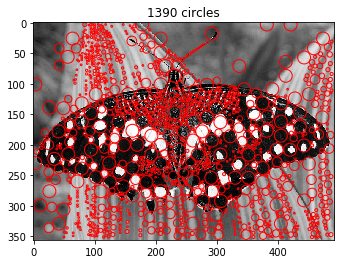

In [1094]:
#Pruning the extra blobs which are overlapping
a = skimage.feature.blob._prune_blobs(np.row_stack((cy4, cx4, sigma_list4)).T, 0.05)
cy_ = a.T[0]
cx_ = a.T[1]
sigma_list_ = a.T[2]
rad_ = np.sqrt(2)*sigma_list_
show_all_circles(data1, cx_, cy_, rad_, color='r')

## Given image 2

In [1129]:
init_factor = 1.75 #Initial scale  
k = 0.5 #The factor which is multiplied by scale each time 
n = 4 #No. of levels in the scale space n 

In [1130]:
#Running the inefficient algorithm and displaying the blobs on the image 
start_time = time.time()
cy4, cx4, sigma_list4, rad4 = efficient_algorithm(data2, init_factor, k, n)
print ('Time for efficient implementation = ', time.time()-start_time)
#show_all_circles(data2, cx4, cy4, rad4, color='r')

Time for efficient implementation =  0.47179412841796875


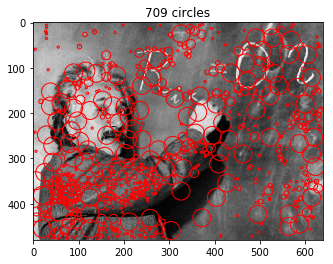

In [1132]:
#Pruning the extra blobs which are overlapping
a = skimage.feature.blob._prune_blobs(np.row_stack((cy4, cx4, sigma_list4)).T, 0.3)
cy_ = a.T[0]
cx_ = a.T[1]
sigma_list_ = a.T[2]
rad_ = np.sqrt(2)*sigma_list_
show_all_circles(data2, cx_, cy_, rad_, color='r')

## Given image 3

In [1136]:
init_factor = 1.5 #Initial scale  
k = 0.75 #The factor which is multiplied by scale each time 
n = 7 #No. of levels in the scale space n 

In [1140]:
#Running the inefficient algorithm and displaying the blobs on the image 
start_time = time.time()
cy4, cx4, sigma_list4, rad4 = efficient_algorithm(data3, init_factor, k, n)
print ('Time for efficient implementation = ', time.time()-start_time)
#show_all_circles(data3, cx4, cy4, rad4, color='r')

Time for efficient implementation =  0.49726247787475586


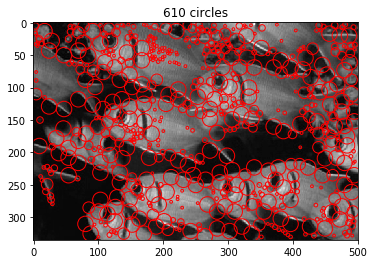

In [1141]:
#Pruning the extra blobs which are overlapping
a = skimage.feature.blob._prune_blobs(np.row_stack((cy4, cx4, sigma_list4)).T, 0.3)
cy_ = a.T[0]
cx_ = a.T[1]
sigma_list_ = a.T[2]
rad_ = np.sqrt(2)*sigma_list_
show_all_circles(data3, cx_, cy_, rad_, color='r')

## Given image 4

In [1148]:
init_factor = 2 #Initial scale  
k = 0.75 #The factor which is multiplied by scale each time 
n = 4 #No. of levels in the scale space n 

In [1152]:
#Running the inefficient algorithm and displaying the blobs on the image 
start_time = time.time()
cy4, cx4, sigma_list4, rad4 = efficient_algorithm(data4, init_factor, k, n)
print ('Time for efficient implementation = ', time.time()-start_time)
#show_all_circles(data4, cx4, cy4, rad4, color='r')

Time for efficient implementation =  0.2510986328125


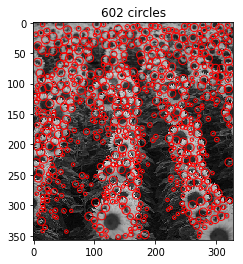

In [1151]:
#Pruning the extra blobs which are overlapping
a = skimage.feature.blob._prune_blobs(np.row_stack((cy4, cx4, sigma_list4)).T, 0.2)
cy_ = a.T[0]
cx_ = a.T[1]
sigma_list_ = a.T[2]
rad_ = np.sqrt(2)*sigma_list_
show_all_circles(data4, cx_, cy_, rad_, color='r')

## New image 1

In [1159]:
init_factor = 2 #Initial scale  
k = 0.75 #The factor which is multiplied by scale each time 
n = 7 #No. of levels in the scale space n 

In [1163]:
#Running the inefficient algorithm and displaying the blobs on the image 
start_time = time.time()
cy4, cx4, sigma_list4, rad4 = efficient_algorithm(data5, init_factor, k, n)
print ('Time for efficient implementation = ', time.time()-start_time)
#show_all_circles(data5, cx4, cy4, rad4, color='r')

Time for efficient implementation =  0.5101478099822998


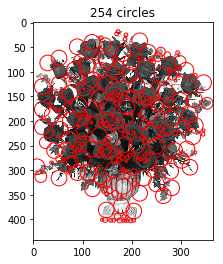

In [1162]:
#Pruning the extra blobs which are overlapping
a = skimage.feature.blob._prune_blobs(np.row_stack((cy4, cx4, sigma_list4)).T, 0.2)
cy_ = a.T[0]
cx_ = a.T[1]
sigma_list_ = a.T[2]
rad_ = np.sqrt(2)*sigma_list_
show_all_circles(data5, cx_, cy_, rad_, color='r')

## New image 2


In [1164]:
init_factor = 2 #Initial scale  
k = 0.75 #The factor which is multiplied by scale each time 
n = 7 #No. of levels in the scale space n 

In [1169]:
#Running the inefficient algorithm and displaying the blobs on the image 
start_time = time.time()
cy4, cx4, sigma_list4, rad4 = efficient_algorithm(data6, init_factor, k, n)
print ('Time for efficient implementation = ', time.time()-start_time)
#show_all_circles(data6, cx4, cy4, rad4, color='r')

Time for efficient implementation =  0.395064115524292


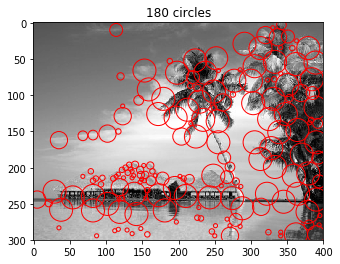

In [1168]:
#Pruning the extra blobs which are overlapping
a = skimage.feature.blob._prune_blobs(np.row_stack((cy4, cx4, sigma_list4)).T, 0.3)
cy_ = a.T[0]
cx_ = a.T[1]
sigma_list_ = a.T[2]
rad_ = np.sqrt(2)*sigma_list_
show_all_circles(data6, cx_, cy_, rad_, color='r')

## New image 3

In [1177]:
init_factor = 2 #Initial scale  
k = 0.5 #The factor which is multiplied by scale each time 
n = 4 #No. of levels in the scale space n 

In [1180]:
#Running the inefficient algorithm and displaying the blobs on the image 
start_time = time.time()
cy4, cx4, sigma_list4, rad4 = efficient_algorithm(data7, init_factor, k, n)
print ('Time for efficient implementation = ', time.time()-start_time)
#show_all_circles(data7, cx4, cy4, rad4, color='r')

Time for efficient implementation =  0.516230583190918


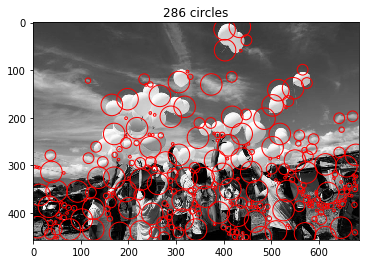

In [1179]:
#Pruning the extra blobs which are overlapping
a = skimage.feature.blob._prune_blobs(np.row_stack((cy4, cx4, sigma_list4)).T, 0.2)
cy_ = a.T[0]
cx_ = a.T[1]
sigma_list_ = a.T[2]
rad_ = np.sqrt(2)*sigma_list_
show_all_circles(data7, cx_, cy_, rad_, color='r')

## New image 4

In [1188]:
init_factor = 2 #Initial scale  
k = 0.5 #The factor which is multiplied by scale each time 
n = 4 #No. of levels in the scale space n 

In [1189]:
#Running the inefficient algorithm and displaying the blobs on the image 
start_time = time.time()
cy4, cx4, sigma_list4, rad4 = efficient_algorithm(data8, init_factor, k, n)
print ('Time for efficient implementation = ', time.time()-start_time)
#show_all_circles(data8, cx4, cy4, rad4, color='r')

Time for efficient implementation =  0.4762535095214844


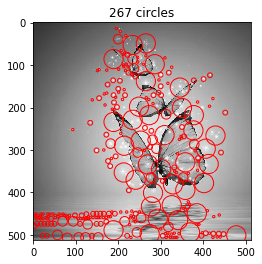

In [1190]:
#Pruning the extra blobs which are overlapping
a = skimage.feature.blob._prune_blobs(np.row_stack((cy4, cx4, sigma_list4)).T, 0.2)
cy_ = a.T[0]
cx_ = a.T[1]
sigma_list_ = a.T[2]
rad_ = np.sqrt(2)*sigma_list_
show_all_circles(data8, cx_, cy_, rad_, color='r')